Custom outputs: ['During our final discussion, I told him about the new submission', 'Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before he is sending again']


Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Device set to use cpu
[nltk_data] Downloading package punkt to C:\Users\Soni
[nltk_data]     18\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggin

HUMARIN Text1: BLEU=0.0976, ROUGE-L=0.3725, CosSim=0.9698
HUMARIN Text2: BLEU=0.2052, ROUGE-L=0.3656, CosSim=0.9043
PEGASUS Text1: BLEU=0.2493, ROUGE-L=0.4696, CosSim=0.9579
PEGASUS Text2: BLEU=0.4495, ROUGE-L=0.5759, CosSim=0.9421
BART Text1: BLEU=0.1439, ROUGE-L=0.5652, CosSim=0.8976
BART Text2: BLEU=0.4175, ROUGE-L=0.6901, CosSim=0.9595


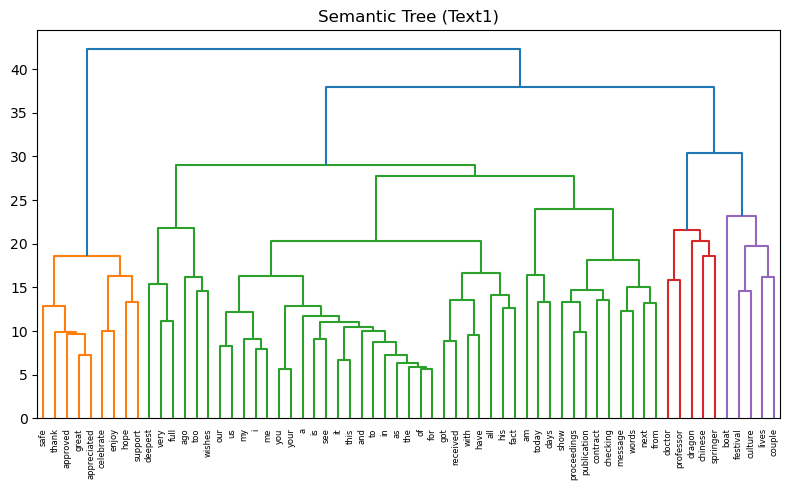


Summury
word2vec: SentCos=0.9534851461648941, Common=None, Align=None
fasttext: SentCos=0.9534851461648941, Common=None, Align=None
glove: SentCos=0.9534851461648941, Common=None, Align=None
bert: SentCos=0.9534851461648941, Common=1.0, Align=0.951892394725066


In [ ]:
# imports
import re, string, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from numpy.linalg import norm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, PegasusTokenizer, PegasusForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 
try:
    from gensim.models import Word2Vec, FastText
    import gensim.downloader as api
    GENSIM_AVAILABLE = True
except Exception:
    GENSIM_AVAILABLE = False

#Input
text1 = """Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication"""
text2 = """During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets"""

#1Α
def custom_reconstruct(sentence: str) -> str:
    s = re.sub(r"\bdiscuss\b", "discussion", sentence)
    s = re.sub(r"updates was", "updates were", s)
    s = re.sub(r"he sending", "he is sending", s)
    return s.strip()

sent1 = "During our final discuss, I told him about the new submission"
sent2 = "Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before he sending again"
custom_outputs = [custom_reconstruct(sent1), custom_reconstruct(sent2)]
print("Custom outputs:", custom_outputs)


#1Β
humarin_pipe = pipeline("text2text-generation", model="humarin/chatgpt_paraphraser_on_T5_base")
pegasus_model = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase")
pegasus_tokenizer = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
pegasus_pipe = pipeline("text2text-generation", model=pegasus_model, tokenizer=pegasus_tokenizer)
bart_model = AutoModelForSeq2SeqLM.from_pretrained("eugenesiow/bart-paraphrase")
bart_tokenizer = AutoTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
bart_pipe = pipeline("text2text-generation", model=bart_model, tokenizer=bart_tokenizer)
bert_model = SentenceTransformer("bert-large-nli-mean-tokens")

texts = [text1, text2]
reconstructed = {"humarin": [], "pegasus": [], "bart": []}
nltk.download('punkt')

for t in texts:
    hum = humarin_pipe(t, max_length=512, do_sample=True, temperature=0.7)[0]['generated_text']
    peg = " ".join([pegasus_pipe(s, max_length=60, do_sample=True, temperature=0.7)[0]['generated_text']
                    for s in sent_tokenize(t) if s.strip()])
    bart_out = bart_pipe("paraphrase: " + t, max_length=512, do_sample=True, temperature=0.7)[0]['generated_text']
    reconstructed["humarin"].append(hum)
    reconstructed["pegasus"].append(peg)
    reconstructed["bart"].append(bart_out)


#1Γ
rouge = Rouge()
smooth = SmoothingFunction().method1
for name, outs in reconstructed.items():
    for idx, (orig, rec) in enumerate(zip(texts, outs), 1):
        bleu = sentence_bleu([orig.split()], rec.split(), weights=(0.5, 0.5), smoothing_function=smooth)  # BLEU-2
        scores = rouge.get_scores(rec, orig)[0]
        emb1, emb2 = bert_model.encode(orig, convert_to_tensor=True), bert_model.encode(rec, convert_to_tensor=True)
        cos_sim = util.cos_sim(emb1, emb2).item()
        print(f"{name.upper()} Text{idx}: BLEU={bleu:.4f}, ROUGE-L={scores['rouge-l']['f']:.4f}, CosSim={cos_sim:.4f}")

#2.1: Custom Workflow (Dendrogram)
def preprocess(text: str):
    return [w.lower().strip(string.punctuation) for w in word_tokenize(text) if any(c.isalnum() for c in w)]

def embed_words(vocab):
    return {w: bert_model.encode(w) for w in vocab}

def plot_dendrogram(embeddings, vocab, title="Semantic Tree"):
    if not vocab: return
    X = np.vstack([embeddings[w] for w in vocab])
    Z = linkage(X, method="ward")
    plt.figure(figsize=(8, 5))
    dendrogram(Z, labels=vocab, leaf_rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

vocab, _ = zip(*Counter(preprocess(text1)).items())
embeddings = embed_words(vocab)
plot_dendrogram(embeddings, vocab, "Semantic Tree (Text1)")

#2.2: Computational Analysis
def cosine(a, b):
    denom = norm(a) * norm(b)
    return 0.0 if denom == 0 else float(np.dot(a, b) / denom)

def clean_tokens(text: str):
    toks = [w.lower() for w in word_tokenize(text)]
    return [w.strip(string.punctuation) for w in toks if any(c.isalnum() for c in w)]

#Train local Word2Vec/FastText
all_texts = [text1, text2] + reconstructed['humarin'] + reconstructed['pegasus'] + reconstructed['bart'] + custom_outputs
sentences = [clean_tokens(s) for t in all_texts for s in sent_tokenize(t)]
sentences = [s for s in sentences if s]
w2v_model = ft_model = glove_model = None
if GENSIM_AVAILABLE and sentences:
    try:
        w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, epochs=20)
        ft_model = FastText(sentences, vector_size=100, window=5, min_count=1, epochs=20)
        glove_model = api.load("glove-wiki-gigaword-50")
    except Exception as e:
        print("Embedding training/loading failed:", e)

#Build AB
pairs = [("A", sent1, custom_outputs[0]), ("A", sent2, custom_outputs[1])]
for mname, outs in reconstructed.items():
    pairs.extend((f"B:{mname}", o, r) for o, r in zip(texts, outs))

#Cache BERT
bert_cache_sent, bert_cache_words = {}, {}
for tag, orig, rec in pairs:
    for t in (orig, rec):
        if t not in bert_cache_sent:
            bert_cache_sent[t] = bert_model.encode(t)
        for w in clean_tokens(t):
            if w not in bert_cache_words:
                bert_cache_words[w] = bert_model.encode(w)

#Evaluation
methods = ["word2vec", "fasttext", "glove", "bert"]
def get_embedding(word: str, method: str):
    w = word.lower()
    if method=="word2vec" and w2v_model and w in w2v_model.wv: return w2v_model.wv[w]
    if method=="fasttext" and ft_model and w in ft_model.wv: return ft_model.wv[w]
    if method=="glove" and glove_model and w in glove_model.key_to_index: return glove_model[w]
    if method=="bert": return bert_cache_words.get(w)
    return None

summary = {m: {"sent": [], "common": [], "align": []} for m in methods}
for tag, orig, rec in pairs:
    toks_o, toks_r = clean_tokens(orig), clean_tokens(rec)
    s_cos = cosine(bert_cache_sent[orig], bert_cache_sent[rec])
    for m in methods:
        sims_common = [1.0 for w in set(toks_o)&set(toks_r) if get_embedding(w,m) is not None]
        emb_o = [get_embedding(w,m) for w in toks_o if get_embedding(w,m) is not None]
        emb_r = [get_embedding(w,m) for w in toks_r if get_embedding(w,m) is not None]
        sims_align = []
        if emb_o and emb_r:
            dists = cdist(np.vstack(emb_o), np.vstack(emb_r), metric="cosine")
            sims_align = 1 - dists.min(axis=1)
        if s_cos: summary[m]["sent"].append(s_cos)
        if sims_common: summary[m]["common"].append(np.mean(sims_common))
        if sims_align is not None and hasattr(sims_align, '__len__') and len(sims_align) > 0:
            summary[m]["align"].append(np.mean(sims_align))
print("\nSummury")
for m, vals in summary.items():
    print(f"{m}: SentCos={np.mean(vals['sent']) if vals['sent'] else None}, "
          f"Common={np.mean(vals['common']) if vals['common'] else None}, "
          f"Align={np.mean(vals['align']) if vals['align'] else None}")

#PCA/t-SNE Visualization
def visualize_embeddings(method, items, prefix):
    words = [w for _, b, a in items for w in clean_tokens(b)+clean_tokens(a)]
    top_words = [w for w, _ in Counter(words).most_common(40)]
    emb_list, labels, groups = [], [], []
    for label, before, after in items:
        for tag,text in [("before", before), ("after", after)]:
            for w in clean_tokens(text):
                if w in top_words:
                    e = get_embedding(w, method)
                    if e is not None:
                        emb_list.append(e); labels.append(w); groups.append(f"{label}_{tag}")
    if len(emb_list)<2: return
    X = np.vstack(emb_list)
    Xp = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(8,6))
    for g in set(groups):
        idxs=[i for i,gg in enumerate(groups) if gg==g]
        plt.scatter(Xp[idxs,0],Xp[idxs,1],label=g)
    for i,lab in enumerate(labels): plt.text(Xp[i,0],Xp[i,1],lab,fontsize=8)
    plt.title(f"PCA - {method}"); plt.legend(); plt.savefig(f"{prefix}_{method}_pca.png"); plt.close()
    try:
        Xt=TSNE(n_components=2,init="pca",random_state=42,learning_rate="auto").fit_transform(X)
        plt.figure(figsize=(8,6))
        for g in set(groups):
            idxs=[i for i,gg in enumerate(groups) if gg==g]
            plt.scatter(Xt[idxs,0],Xt[idxs,1],label=g)
        for i,lab in enumerate(labels): plt.text(Xt[i,0],Xt[i,1],lab,fontsize=8)
        plt.title(f"t-SNE - {method}"); plt.legend(); plt.savefig(f"{prefix}_{method}_tsne.png"); plt.close()
    except Exception as e: print("t-SNE failed:",e)

items_A=[("A",sent1,custom_outputs[0]),("A",sent2,custom_outputs[1])]
items_B=[(f"B_{m}",o,r) for m,outs in reconstructed.items() for o,r in zip(texts,outs)]
for m in methods:
    visualize_embeddings(m, items_A, "A_viz")
    visualize_embeddings(m, items_B, "B_viz")